In [1]:
#import jax
#import jax.numpy as jnp
import     numpy as np
import matplotlib.pyplot as plt
from data      import make_rectangle, insert_shape, plot_data
from agent     import Agent
from tst_optim import cas_train_cbf, get_h
from utils     import plot_cbf

import hj_reachability as hj

from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

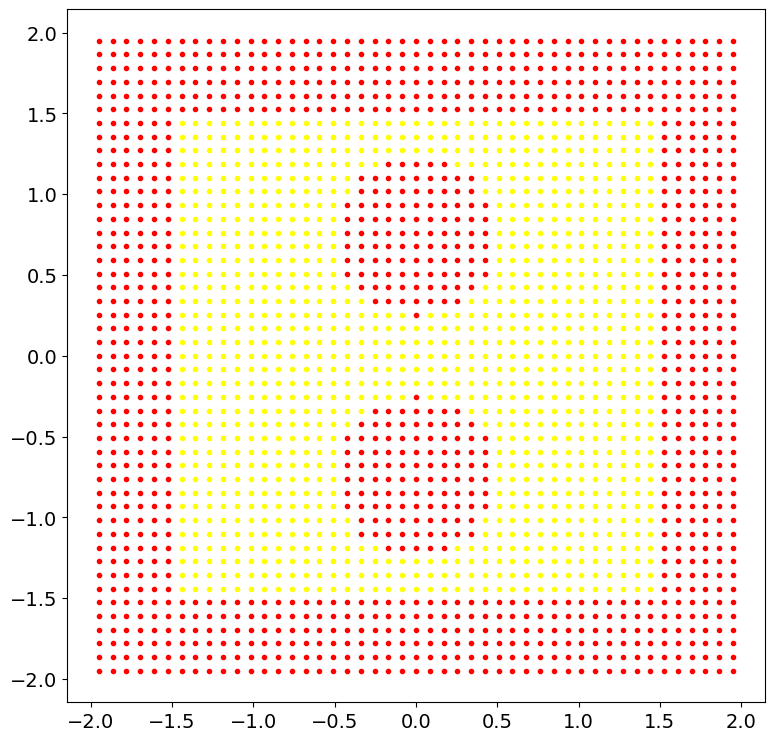

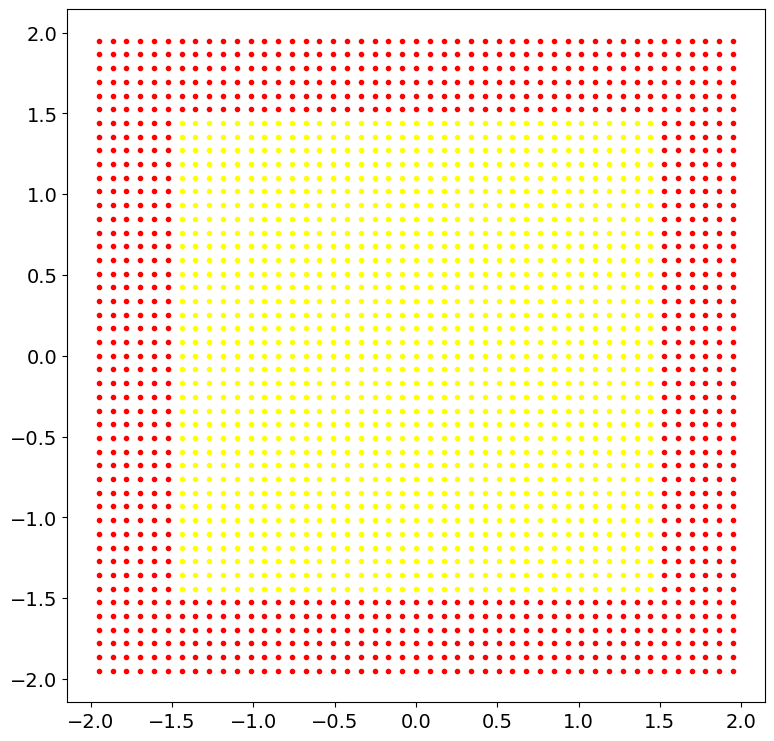

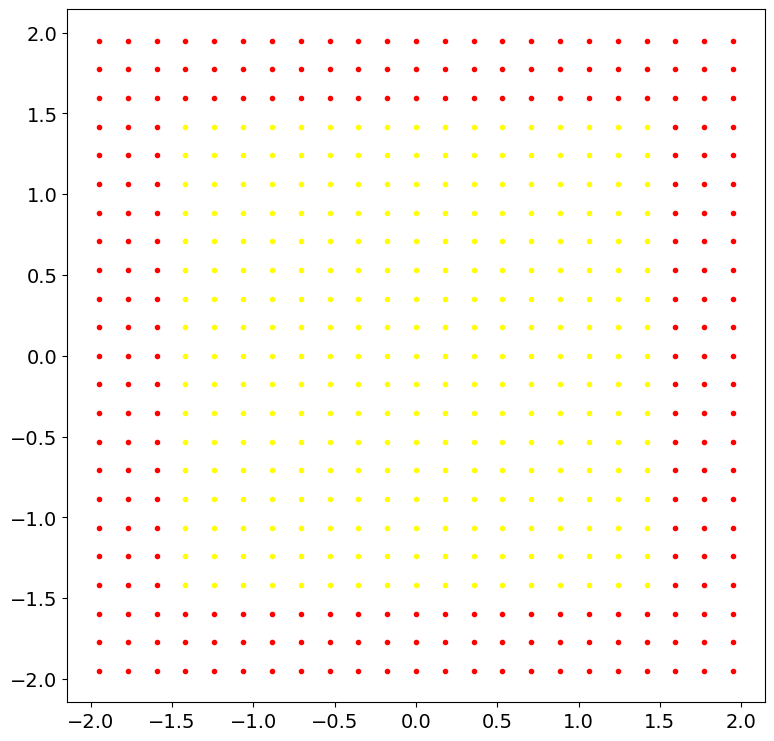

In [2]:
#########################
### Data Construction ###
#########################

# grid parameters 
width         = 3
unsafe_margin = 0.3

# main grid -- unsafe_margin defines wall obstacles
grid, obs_dict = make_rectangle(height=width, width=width, density=150, unsafe_margin=unsafe_margin, center=(0,0))

# generate two circular obstacles
obs_dict = insert_shape(np.array([0,  0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)
obs_dict = insert_shape(np.array([0, -0.75]), grid, obs_dict, shape='circle', scale=0.5, theta=0)

# supplementary grids for [c]enters and unsafe [s]amples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=150, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=35 , unsafe_margin=unsafe_margin, center=(0,0))

# show the created grids
plot_data(  grid,   obs_dict)
plot_data(c_grid, c_obs_dict)
plot_data(s_grid, s_obs_dict)

In [3]:
###########################
### Agent Configuration ###
###########################

dynamics = hj.systems.Planar()
bf = 31   # csrbf order
b  = 0   # offset 
s  = 1 # csrbf zeroing
sensor_radius = 1
rx = 1.5 # sample radius
nm = 0.2 # nm * n_safe = number of neighbors to consider
p  = 0.6 # num neighber percentile under which boundary
rc = 1   # radius around scan in which centers are chosen

# make agent
a = Agent(dynamics, np.array([0, 0]), grid, obs_dict, width=width, 
                                            sensor_radius=1, 
                                            bf = bf, 
                                            b = b, 
                                            s = s)

In [4]:
############################
### Scan for initial CBF ###
############################

# scan for obstacles and generate unsafe samples
scan_safe, scan_unsafe = a.scan()
samples  = a.sample(rx, grid=s_grid)
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: # in case no obstacles detected
    x_unsafe = samples

# create buffer region
n_safe = scan_safe.shape[0]
x_buffer, x_safe = a.make_buffer(scan_safe, int(nm * n_safe), p)

# collect centers within rc from c_grid
C = []
for x in c_grid:
    if np.linalg.norm(x - a.pos) <= rc:
        C.append(x)
C = np.array(C)
print(C.shape)
a.centers.append(C)

(437, 2)


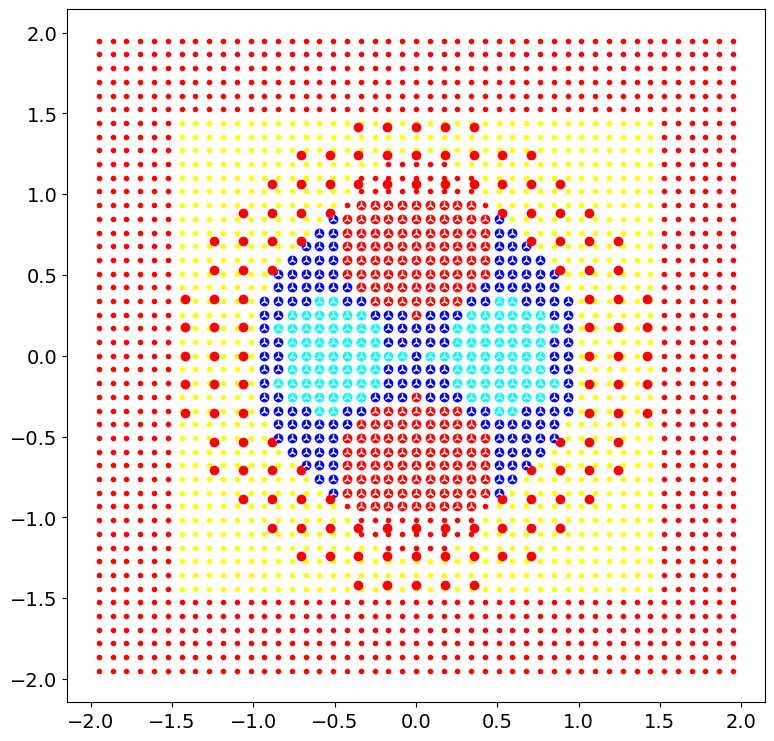

In [5]:
#############################
### Plot initial CBF data ###
#############################

plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                           (x_buffer, "blue"  , 'o'), 
                           (x_unsafe, "red"   , 'o'),
                           (C       , "white" , '2')])

In [6]:
##############################
### Initial CBF Parameters ###
##############################
theta_max    = 10
max_elem     = 100
gamma_safe   = 0.3
gamma_unsafe = 0
gamma_dyn    = 0.1

In [7]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

start = timer()
theta=cas_train_cbf(a, x_safe, x_buffer, x_unsafe, gamma_safe, gamma_unsafe, gamma_dyn, verbose=True)
elapsed_time = timer() - start
print("time:", elapsed_time)

a.thetas.append(theta)

CasADi - 2024-06-17 06:23:04 MESSAGE("nlp::init") [.../casadi/core/function_internal.cpp:547]
CasADi - 2024-06-17 06:23:04 MESSAGE("nlp::init") [.../casadi/core/x_function.hpp:327]
CasADi - 2024-06-17 06:23:04 MESSAGE("nlp::init") [.../casadi/core/mx_function.cpp:113]
CasADi - 2024-06-17 06:23:04 MESSAGE("Using live variables: work array is 8 instead of 6925") [.../casadi/core/mx_function.cpp:326]
CasADi - 2024-06-17 06:23:04 MESSAGE("solver::init") [.../casadi/core/function_internal.cpp:547]
CasADi - 2024-06-17 06:23:04 MESSAGE("solver::create_function nlp_grad:[x, p, lam:f, lam:g]->[f, g, grad:gamma:x, grad:gamma:p]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-06-17 06:23:06 MESSAGE("solver::create_function nlp_f:[x, p]->[f]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-06-17 06:23:06 MESSAGE("solver::create_function nlp_g:[x, p]->[g]") [.../casadi/core/oracle_function.cpp:219]
CasADi - 2024-06-17 06:23:06 MESSAGE("solver::create_function nlp_grad_f:[x, p]->[

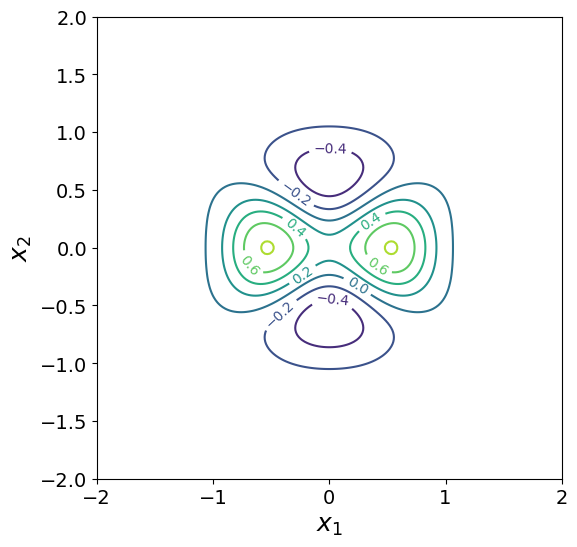

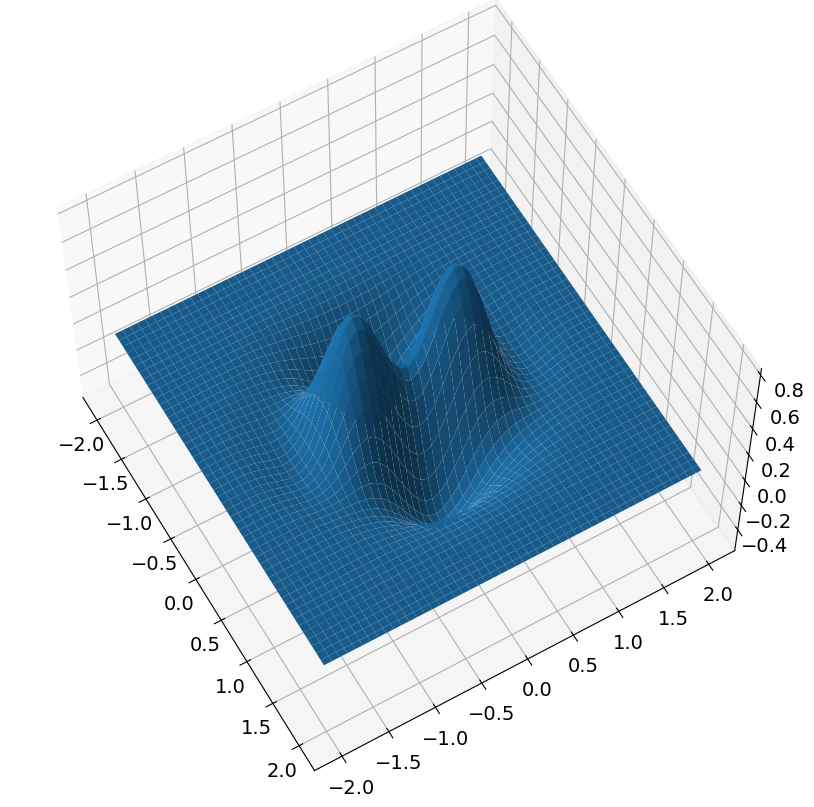

time: 3.2189440270003615


In [8]:
########################
### Plot Initial CBF ###
########################

start = timer()

plot_cbf(a, np.array(a.centers), np.array(a.thetas))

elapsed_time = timer() - start
print("time:", elapsed_time)

In [11]:
##################################
### Configure Safe Exploration ###
##################################

tol  = 0.5 # h-value at which to halt approach
tend = 50  # Duration of boundary approach
T    = 3   # MPC horizon (default timestep is 0.05)
N    = 30  # number of CBFs to learn

target: [-0.69715749  1.44696887]
target in goto [-0.69715749  1.44696887]
position is [0 0]
h is 0.2684716087654054
start time is 0


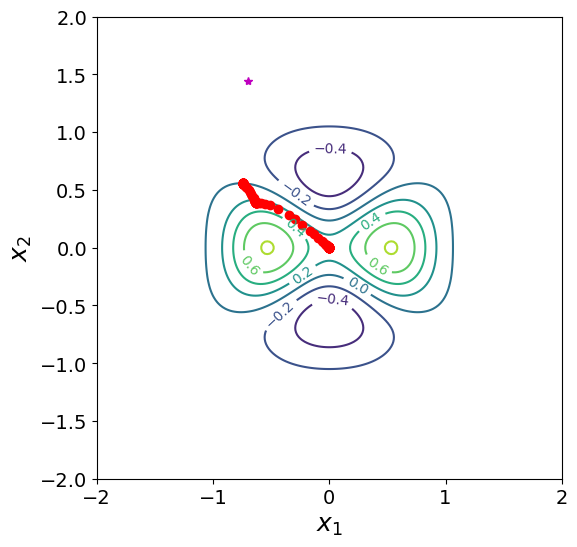

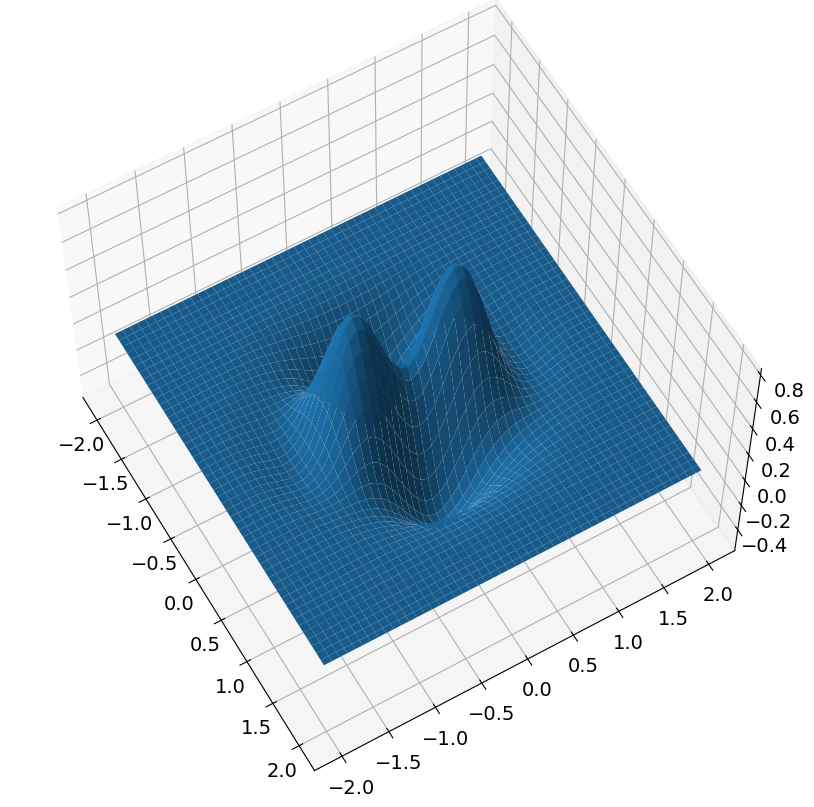

new position is [-0.74469774  0.55791833]
h is now -3.662334695344032e-05
new time is 50
dx: 0.9305093139299045


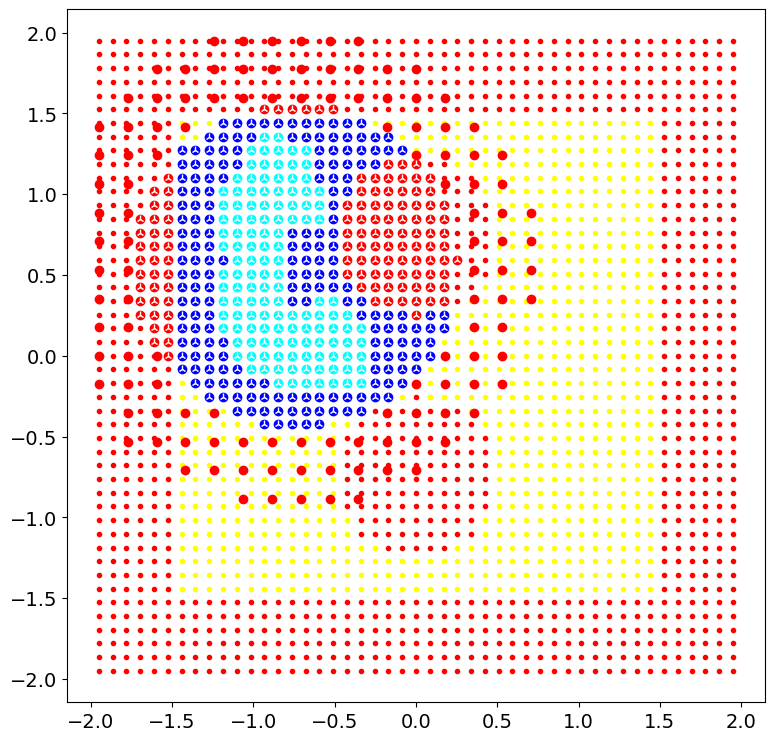

In [ ]:
##########################
### Safe Exploration ###
##########################

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    prev_pos = a.pos  
    while np.linalg.norm(a.pos - prev_pos) <= tol:    
        target=a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
        while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
            target=a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
        print("target:", target) 
        a.goto(target, T=T, tend=tend, tol=tol) 
        print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################
    ### unsafe data:
    scan_safe, scan_unsafe = a.scan()
    samples  = a.sample(rx, grid=s_grid) 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples 
    ### safe and buffer data:
    n_safe = scan_safe.shape[0]
    x_buffer, x_safe = a.make_buffer(scan_safe, int(nm * n_safe), p)
    C  = [] 
    ### centers:
    for x in c_grid:
        if np.linalg.norm(x - a.pos) <= rc:
            C.append(x)
    C = np.array(C)
    a.centers.append(C)
    plot_data(grid, obs_dict, [(x_safe  , "cyan"  , 'o'), 
                               (x_buffer, "blue"  , 'o'), 
                               (x_unsafe, "red"   , 'o'),
                               (C       , "white" , '2')])
    #####################
    ### Learn new CBF ###
    #####################
    theta=cas_train_cbf(a, x_safe, x_buffer, x_unsafe, gamma_safe, gamma_unsafe, gamma_dyn)
    a.thetas.append(theta)
    plot_cbf(np.array(a.centers), np.array(a.thetas))